In [14]:
#importamos las librerias necesarias

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import requests

In [15]:
#obtenemos los datos requeridos
# URL del archivo JSON en GitHub
url = "https://raw.githubusercontent.com/Ar-Rxul/proyecto_distribucion/main/datos_cdmx.json"


# Realizar solicitud HTTP para obtener el contenido del archivo JSON
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
    # Obtener el contenido del archivo JSON
    json_data = response.json()

    # Ahora puedes utilizar el contenido del archivo JSON en tu código de Python
    # Por ejemplo, imprimir el contenido del archivo JSON
    print("El json se obtuvo correctamente")
else:
    print("Error al obtener el archivo JSON:", response.status_code)

#creamos un dataframe con los datos obtenidos
datos = pd.DataFrame(json_data)

# Crear un DataFrame a partir del diccionario de datos
df = pd.DataFrame(datos)

# Obtener los arrays requeridos para ejecutar minimos cuadrados
poblacion_por_ano = np.array(df.values.tolist())
poblacion = np.array(df["Población en la CDMX"].tolist())
pob = np.array([[1, año] for año in df["Año"]])



El json se obtuvo correctamente


In [16]:
#aqui estaran las funciones que se utilizaran para minimos cuadrados

# Función para obtener la matriz transpuesta de A
def transpuesta(A):
    """
    Calcula y devuelve la matriz transpuesta de A.

    Args:
    A: Matriz de entrada.

    Returns:
    La matriz transpuesta de A.
    """
    m, n = A.shape
    D = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            D[i, j] = A[j, i]
    return D

# Función para multiplicar dos matrices A y B
def multMat(A, B):
    """
    Multiplica dos matrices A y B y devuelve el resultado.

    Args:
    A: Matriz de entrada.
    B: Matriz de entrada.

    Returns:
    La matriz resultante de la multiplicación de A y B.
    """
    m, n = A.shape
    p, q = B.shape
    if n != p:
        print("Error")
        return None
    C = np.zeros((m, q))
    for i in range(m):
        for j in range(q):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]
    return C

# Función para multiplicar una matriz y un vector
def multiplicar_matriz_vector(matriz, vector):
    """
    Multiplica una matriz y un vector y devuelve el resultado.

    Args:
    matriz: Matriz de entrada.
    vector: Vector de entrada.

    Returns:
    El vector resultante de la multiplicación de la matriz y el vector.
    """
    filas = len(matriz)
    columnas = len(matriz[0])
    if columnas != len(vector):
        raise ValueError("Las dimensiones de la matriz y el vector no son compatibles.")

    resultado = [0] * filas
    for i in range(filas):
        for j in range(columnas):
            resultado[i] += matriz[i][j] * vector[j]

    return resultado

# Función para resolver un sistema de ecuaciones lineales
def solucionador(A, b):
    """
    Resuelve un sistema de ecuaciones lineales dado por la matriz A y el vector b.

    Args:
    A: Matriz de coeficientes del sistema.
    b: Vector de términos independientes.

    Returns:
    El vector solución del sistema.
    """
    m, n = A.shape
    if m != n:
        print("Error: La matriz A debe ser cuadrada.")
        return None
    Ab = np.concatenate((A, b.reshape(-1, 1)), axis=1)
    for i in range(n):
        a = Ab[i, i]
        for j in range(i + 1, n):
            b = Ab[j, i]
            Ab[j, :] = Ab[j, :] - Ab[i, :] * b / a
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (Ab[i, n] - Ab[i, i + 1:n] @ x[i + 1:n]) / Ab[i, i]
    return x

# Función para obtener los coeficientes de la aproximación lineal de mínimos cuadrados
def Coeficientes(A, B):
    """
    Calcula los coeficientes de la aproximación lineal de mínimos cuadrados.

    Args:
    A: Matriz de entrada.
    B: Vector de entrada.

    Returns:
    Los coeficientes de la aproximación lineal.
    """
    A_trans = transpuesta(A)
    A_sol = multMat(A_trans, A)
    A_sol = np.array(A_sol)

    B_t = multiplicar_matriz_vector(A_trans, B)
    B_t = np.array(B_t)
    coeficientes = solucionador(A_sol, B_t)
    return coeficientes

# Función para graficar los datos y la aproximación lineal
def grafica(A, B):
    """
    Grafica los datos y la aproximación lineal de mínimos cuadrados.

    Args:
    A: Matriz de entrada.
    B: Vector de entrada.

    Returns:
    None
    """
    coeficientes = Coeficientes(A, B)
    x = np.linspace(1980, 2020, len(A))
    recta = lambda x: coeficientes[0] + coeficientes[1] * x
    costo = lambda y, yaprox: np.sum((y - yaprox) ** 2)
    yaprox = recta(x)
    error = costo(B, yaprox)
    par = {'title': 'poblacion vs tiempo',
           'xlabel': 'años',
           'ylabel': 'poblacion (en millones de personas)'}
    plt.plot(x, yaprox, '-', label='Aproximación')
    plt.plot(A[:, 1], B, 'o', label='Datos')
    plt.title(par['title'])
    plt.xlabel(par['xlabel'])
    plt.ylabel(par['ylabel'])
    plt.text(x[-1], yaprox[-1], f'Error cuadrático: {error:.2f}', verticalalignment='top', horizontalalignment='right')
    plt.legend()


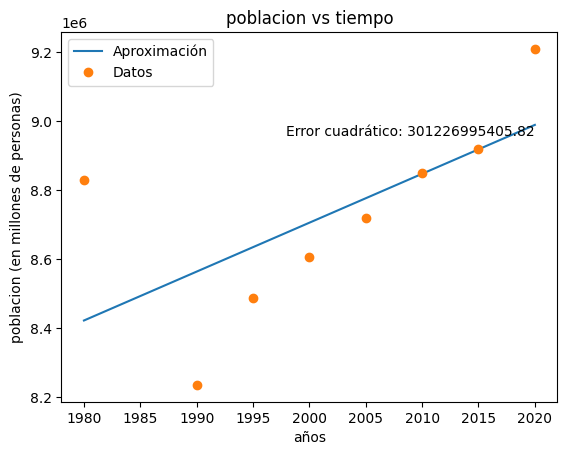

In [17]:
def main(): 
    #aqui se ejecutan las funciones con los datos recopilados
    #aqui se genera la grafica con los datos obtenidos

    grafica(pob, poblacion)
    plt.show()

if __name__ == "__main__":
    main()
    


In [18]:
#aqui estan las funciones necesaerias para modelar la distribucion de la poblacion usando el metodo de montecarlo

#aqui se guardaran los coeficientes de la aproximacion lineal
coeficientes = Coeficientes(pob, poblacion)

# Función para generar una semilla aleatoria
def generar_semilla(i):
    # Obtener el tiempo actual y el identificador de proceso
    tiempo_actual = int(time.time() * 1000*(np.pi**3)) 
    proceso_id = os.getpid()

    # Combinar la información para generar una semilla distinta
    semilla = tiempo_actual ^ (proceso_id * i*7)

    return semilla

# Función para generar un número aleatorio en el intervalo [valor_min, valor_max]
def aleatorio(i, valor_min, valor_max):
    semilla = generar_semilla(i)
    a = 1664525
    c = 1013904223
    m = 2**3+np.pi*3

    # Aplicar una operación matemática a la semilla para obtener un número aleatorio en el intervalo dado
    semilla = (a * semilla + c) % m
    numero = valor_min + (semilla / m) * (valor_max - valor_min)

    return numero


# Función para generar puntos aleatorios dentro de la Ciudad de México
def generar_puntos_aleatorios(n):

      # Para obtener los mismos resultados cada vez que se ejecute el código
    latitud_min, latitud_max = 19.0, 19.7  # Límites de latitud de la Ciudad de México
    longitud_min, longitud_max = -99.3, -98.9  # Límites de longitud de la Ciudad de México
    latitudes = []
    longitudes = []

    for i in range(n):
        latitudes.append(aleatorio(i, latitud_min, latitud_max))
        longitudes.append(aleatorio(i + 1, longitud_min, longitud_max))
    return latitudes, longitudes

# Función para asignar personas a cada punto según la distribución obtenida en el modelo matemático
def asignar_poblacion(latitudes, longitudes):
    poblacion = coeficientes[0] + coeficientes[1] * latitudes
    return poblacion.astype(int)


# Visualizar la distribución de la población generada
def graficar_poblacion(n):
    
    #generar puntos aleatorios
    lat, long = generar_puntos_aleatorios(n)
    latitudes = np.array(lat)
    longitudes = np.array(long)
    poblacion = asignar_poblacion(latitudes, longitudes)

    # Graficar los puntos aleatorios
    plt.scatter(longitudes, latitudes, c=poblacion, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Población')
    plt.title('Distribución de la población en la Ciudad de México')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.show()


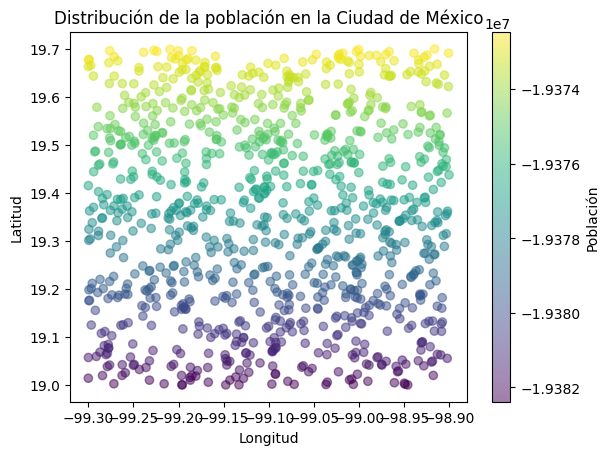

In [22]:
# Ejecutar la función para generar y visualizar la distribución de la población
def main():     

    graficar_poblacion(1000)

if __name__ == '__main__':
    main()  

In [11]:

#aqui se haran las predicciones del crecimiento de la poblacion en los proximos años
def prediccion_poblacion():
    while True:
        try:
            a = int(input("Escribe el año en el que quieres saber la población: "))
            poblacion = np.round(coeficientes[0] + coeficientes[1] * a, 0)
            print(f"La población en el año {a} será de {poblacion} millones de personas.")
           
        except ValueError:
            print("Debes escribir un número entero.")
        
        opcion = input("¿Deseas realizar otra predicción? (s/n): ")
        if opcion.lower() == "n":
            break  # Termina el bucle si la opción no es "s"



In [12]:
def main():
    prediccion_poblacion()

if __name__ == '__main__':
    main()


La población en el año 2025 será de 9060596.0 millones de personas.
La población en el año 2030 será de 9131491.0 millones de personas.
